In [1]:
import numpy as np
import pandas as pd
from google.cloud import bigquery

In [2]:
client = bigquery.Client()

In [35]:
query_string = """
select
    HGNC_gene_symbol,
    avg(normalized_count) as normalized_count_mean,
    count(*) as n_samples_hg19
FROM (
    select
        aliquot_barcode,
        HGNC_gene_symbol,
        sum(normalized_count) as normalized_count
    from `gdc_tcga_skcm_subset.RNAseq_hg19_gdc_current`
    where aliquot_barcode in (
        select aliquot_barcode 
        from `gdc_tcga_skcm_subset.aliquot2caseIDmap_current`
        where sample_type_name = "Metastatic"
    )
    group by 1, 2
)
group by 1
order by 1
;
"""

query_job = client.query(query_string)
tcga_skcm_hg19 = query_job.to_dataframe(progress_bar_type="tqdm")

Query complete after 8.35s: : 3query [00:08,  2.78s/query]                                                    
Downloading: 100%|██████████| 20183/20183 [00:01<00:00, 15848.10rows/s]


In [36]:
query_string = """
select
    gene_name,
    avg(HTSeq__Counts) as HTSeq__Counts_mean,
    avg(HTSeq__FPKM) as HTSeq__FPKM_mean,
    avg(HTSeq__FPKM_UQ) as HTSeq__FPKM_UQ_mean,
    count(*) as n_samples_hg38
FROM (
    select
        aliquot_barcode,
        gene_name,
        sum(HTSeq__Counts) as HTSeq__Counts,
        sum(HTSeq__FPKM) as HTSeq__FPKM,
        sum(HTSeq__FPKM_UQ) as HTSeq__FPKM_UQ,
        
    from `gdc_tcga_skcm_subset.RNAseq_hg38_gdc_current`
    where aliquot_barcode in (
        select aliquot_barcode 
        from `gdc_tcga_skcm_subset.aliquot2caseIDmap_current`
        where sample_type_name = "Metastatic"
    )
    group by 1, 2
)
group by 1
order by 1
;
"""

query_job = client.query(query_string)
tcga_skcm_hg38 = query_job.to_dataframe(progress_bar_type="tqdm")

Query complete after 10.39s: : 3query [00:10,  3.46s/query]                                                   
Downloading: 100%|██████████| 19712/19712 [00:01<00:00, 16266.94rows/s]


In [37]:
both = pd.concat([tcga_skcm_hg19.set_index("HGNC_gene_symbol"), tcga_skcm_hg38.set_index("gene_name")], axis=1, join="inner")

In [38]:
both.isna().sum()

normalized_count_mean    0
n_samples_hg19           0
HTSeq__Counts_mean       0
HTSeq__FPKM_mean         0
HTSeq__FPKM_UQ_mean      0
n_samples_hg38           0
dtype: int64

In [39]:
both.corr()

normalized_count_mean  n_samples_hg19  \
normalized_count_mean               1.000000             NaN   
n_samples_hg19                           NaN             NaN   
HTSeq__Counts_mean                  0.981926             NaN   
HTSeq__FPKM_mean                    0.798523             NaN   
HTSeq__FPKM_UQ_mean                 0.794732             NaN   
n_samples_hg38                           NaN             NaN   

                       HTSeq__Counts_mean  HTSeq__FPKM_mean  \
normalized_count_mean            0.981926          0.798523   
n_samples_hg19                        NaN               NaN   
HTSeq__Counts_mean               1.000000          0.804140   
HTSeq__FPKM_mean                 0.804140          1.000000   
HTSeq__FPKM_UQ_mean              0.799022          0.999513   
n_samples_hg38                        NaN               NaN   

                       HTSeq__FPKM_UQ_mean  n_samples_hg38  
normalized_count_mean             0.794732             NaN  
n_samples_hg19                         NaN             NaN  
HTSeq__Counts_mean                0.799022             NaN  
HTSeq__FPKM_mean                  0.999513             NaN  
HTSeq__FPKM_UQ_mean               1.000000             NaN  
n_samples_hg38                         NaN             NaN

In [40]:
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.io

# plotly.io.renderers.default = "jupyterlab+png"

In [41]:
fig = px.scatter(both, x="HTSeq__Counts_mean", y="normalized_count_mean", trendline="ols")

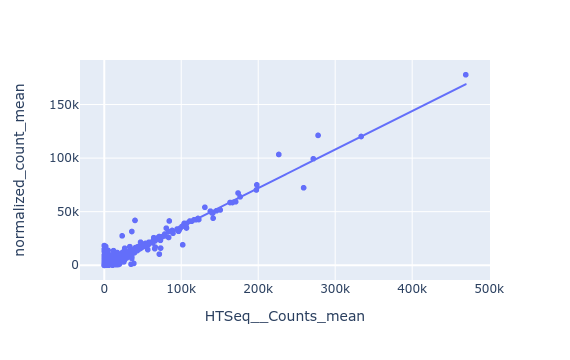

In [42]:
fig

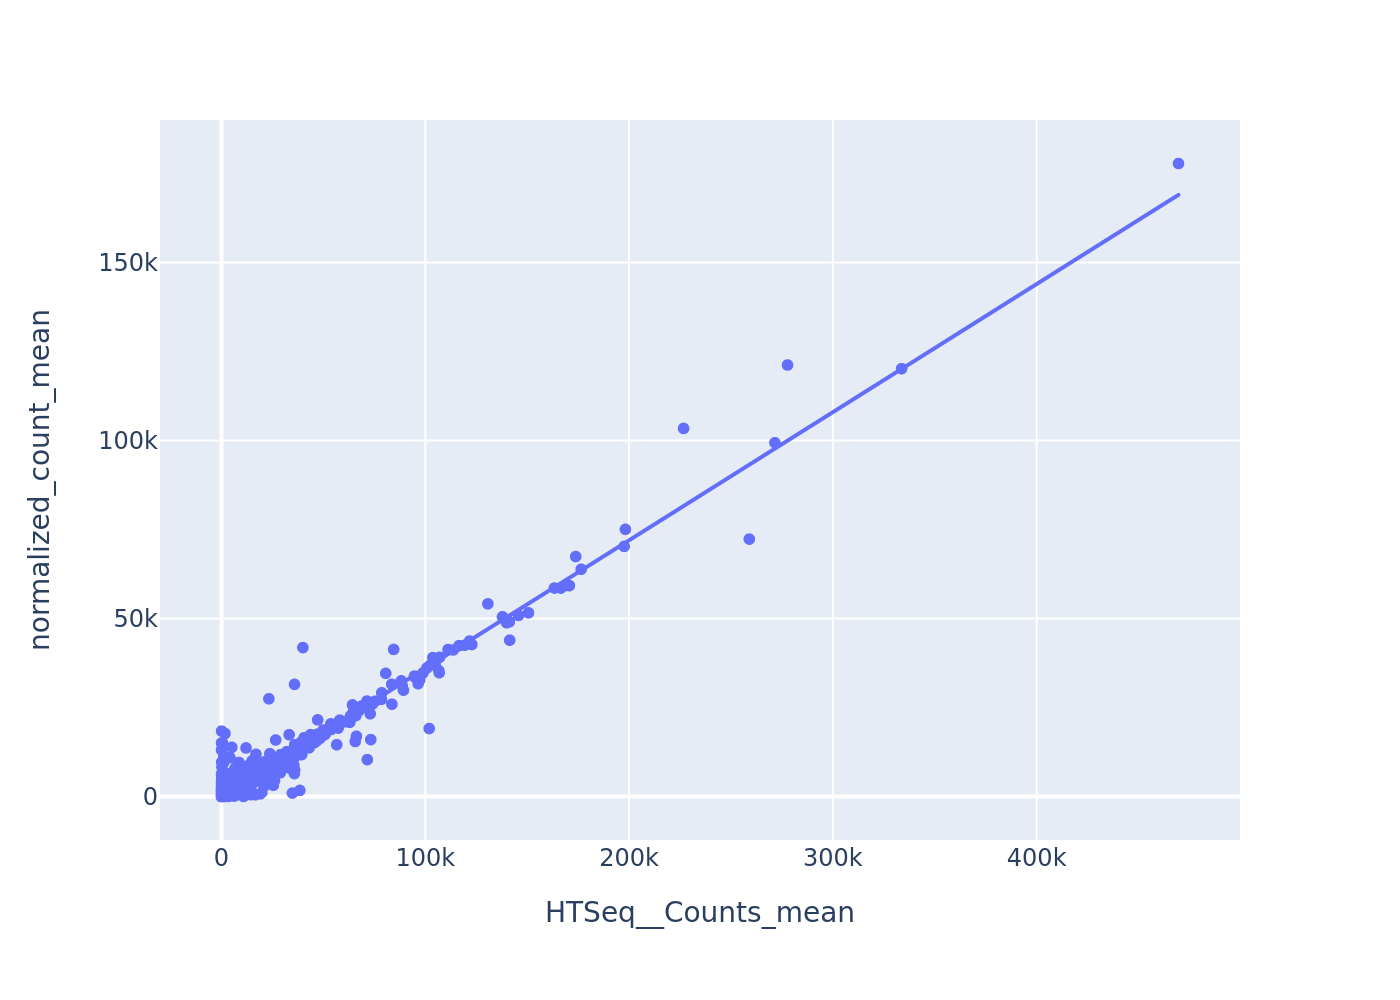

In [43]:
fig.show(height=500, scale=2, renderer="png")

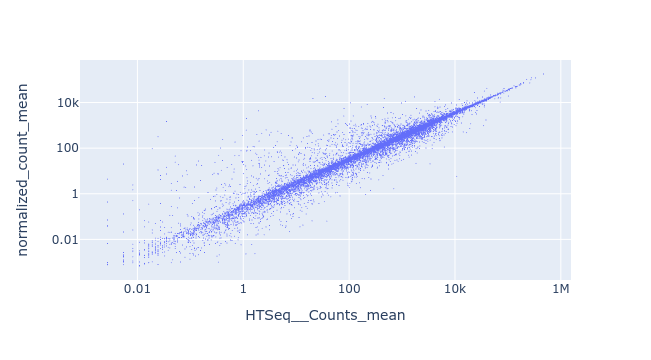

In [52]:
fig = px.scatter(both, x="HTSeq__Counts_mean", y="normalized_count_mean", log_x=True, log_y=True)
fig.update_traces(marker_size=1)

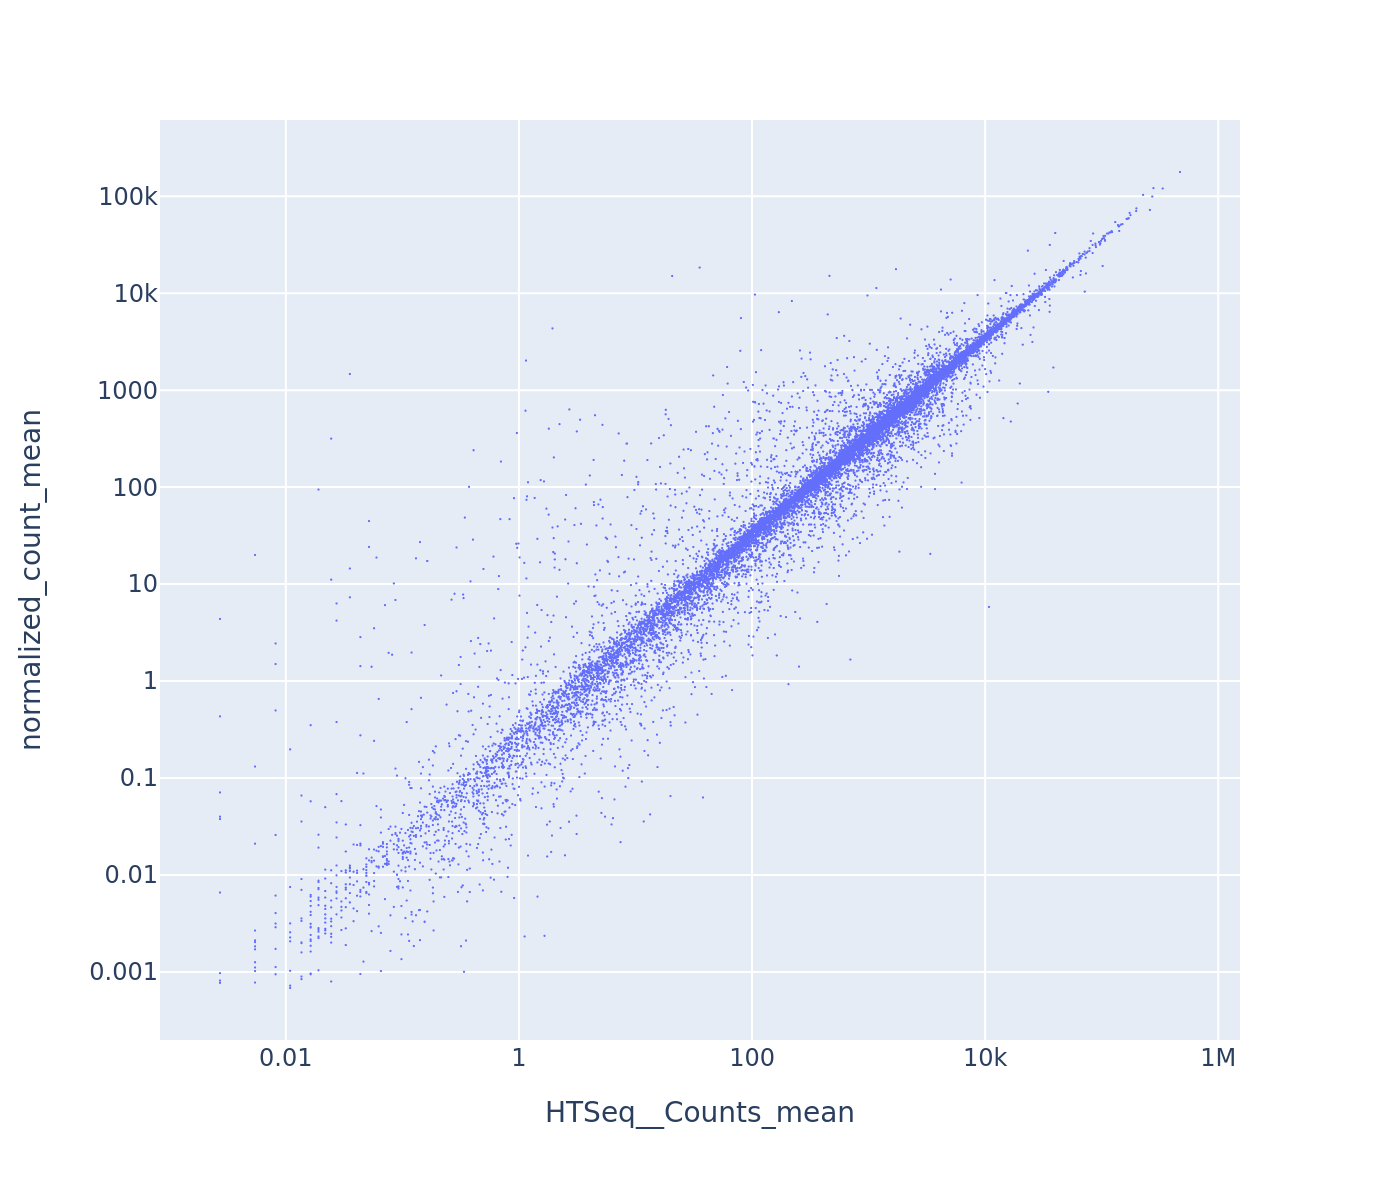

In [53]:
fig.show(height=600, scale=2, renderer="png")